In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

In [2]:
# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.2f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

AutoGluon을 진행하고 나서, 해당 데이터에서는 LightGBM이 뛰어난 성능이라는 점을 파악함. <br><br>
AutoGluon에서 생각한 Feature Importance도 반영해서 컬럼 선택

#### 📊 각 모델별 Feature Importance 비교

# 각 모델 별 Feature Importance

| Feature 순위 | 로지스틱 회귀 (랜덤 언더 샘플링) | 로지스틱 회귀 (가중치) | 랜덤 포레스트 (랜덤 언더 샘플링) | XGBoost (랜덤 언더 샘플링) | LightGBM (랜덤 언더 샘플링) | LightGBM (가중치) | CatBoost (랜덤 언더 샘플링) | AutoGloun |
|------|------------------------------------------|------------------------------|--------------------------------------|--------------------------------|--------------------------------|----------------------|--------------------------------|--------------------------------|
| 1    | VOC_STOP_CANCEL_MONTH1_YN            | VOC_STOP_CANCEL_MONTH1_YN   | TOTAL_USED_DAYS                      | VOC_STOP_CANCEL_MONTH1_YN   | AGMT_END_SEG                        | AGMT_END_SEG                       | AGMT_END_SEG                          | MONTHS_REMAINING  |                            
| 2    | CH_LAST_DAYS_BF_GRP                          | CH_LAST_DAYS_BF_GRP                 | CH_HH_AVG_MONTH1                  | CH_LAST_DAYS_BF_GRP                 | TOTAL_USED_DAYS                    | TOTAL_USED_DAYS                   | VOC_STOP_CANCEL_MONTH1_YN | TOTAL_USED_DAYS                   |
| 3    | AGMT_END_SEG                                    | AGMT_END_SEG                            | CH_25_RATIO_1MONTH                | VOC_TOTAL_MONTH1_YN              | AGE_GRP10                               | AGE_GRP10                               | CH_LAST_DAYS_BF_GRP               | CH_HH_AVG_MONTH1               |
| 4    | TV_I_CNT                                              | TV_I_CNT                                      | VOC_STOP_CANCEL_MONTH1_YN | BUNDLE_YN                                 | CH_HH_AVG_MONTH1                | CH_LAST_DAYS_BF_GRP             | TOTAL_USED_DAYS                     | INHOME_RATE                          |
| 5    | PAID_CHNL_CNT_GRP                            | PAID_CHNL_CNT_GRP                    | AGMT_END_SEG                          | AGMT_END_SEG                            | CH_LAST_DAYS_BF_GRP              | INHOME_RATE                          | VOC_TOTAL_MONTH1_YN            | SCRB_PATH_NM_GRP                |
| 6    | VOC_TOTAL_MONTH1_YN                      | VOC_TOTAL_MONTH1_YN               | VOC_TOTAL_MONTH1_YN            | AGMT_KIND_NM                           | INHOME_RATE                           | TV_I_CNT                                  | BUNDLE_YN                               | CH_LAST_DAYS_BF_GRP             |
| 7    | BUNDLE_YN                                          | BUNDLE_YN                                 | AGE_GRP10                                 | TOTAL_USED_DAYS                        | SCRB_PATH_NM_GRP                 | CH_HH_AVG_MONTH1                | INHOME_RATE                            | CH_25_RATIO_1MONTH             |
| 8    | AGMT_KIND_NM                                   | AGMT_KIND_NM                           | CH_LAST_DAYS_BF_GRP                | MEDIA_NM_GRP                            | TV_I_CNT                                  | SCRB_PATH_NM_GRP                 | CH_HH_AVG_MONTH1                 | CH_FAV_RNK1                          |
| 9    | CH_FAV_RNK1                                       | CH_FAV_RNK1                               | INHOME_RATE                            | DIGITAL_GIGA_YN                          | CH_25_RATIO_1MONTH              | SVC_USE_DAYS_GRP                    | AGMT_KIND_NM                        | AGE_GRP10                              |
| 10   | SVOD_SCRB_CNT_GRP                           | SVOD_SCRB_CNT_GRP                   | SCRB_PATH_NM_GRP                   | CH_FAV_RNK1                                | VOC_TOTAL_MONTH1_YN           | AGMT_KIND_NM                        | AGE_GRP10                                | AGMT_KIND_NM                       |
| 11   | TOTAL_USED_DAYS                                | DIGITAL_GIGA_YN                         | CH_FAV_RNK1                             | INHOME_RATE                               | SVC_USE_DAYS_GRP                   | VOC_TOTAL_MONTH1_YN           | TV_I_CNT                                   |
| 12   | STB_RES_1M_YN                                    | STB_RES_1M_YN                            | AGMT_KIND_NM                         | STB_RES_1M_YN                             | AGMT_KIND_NM                        | CH_FAV_RNK1                            | MEDIA_NM_GRP                         |
| 13   | DIGITAL_GIGA_YN                                 | MEDIA_NM_GRP                           | TV_I_CNT                                    | CH_HH_AVG_MONTH1                   | CH_FAV_RNK1                             | BUNDLE_YN                              | CH_FAV_RNK1                             |
| 14   | INHOME_RATE                                      | AGE_GRP10                                  | PROD_NM_GRP                           | AGE_GRP10                                   | BUNDLE_YN                               | CH_25_RATIO_1MONTH               | SCRB_PATH_NM_GRP                  |
| 15   | MEDIA_NM_GRP                                   | TOTAL_USED_DAYS                       | SVC_USE_DAYS_GRP                    | PAID_CHNL_CNT_GRP                    | VOC_STOP_CANCEL_MONTH1_YN | PROD_NM_GRP                          | PROD_NM_GRP                           |
| 16   | AGE_GRP10                                          | INHOME_RATE                              | EMAIL_RECV_CLS_NM                  | PROD_NM_GRP                             | PROD_NM_GRP                          | VOC_STOP_CANCEL_MONTH1_YN | STB_RES_1M_YN                          |
| 17   | SCRB_PATH_NM_GRP                            | SCRB_PATH_NM_GRP                    | SMS_SEND_CLS_NM                     | PROD_ONE_PLUS_YN                     | MEDIA_NM_GRP                         | MEDIA_NM_GRP                         | SVC_USE_DAYS_GRP                    |
| 18   | PROD_ONE_PLUS_YN                           | PROD_ONE_PLUS_YN                     | BUNDLE_YN                               | TV_I_CNT                                      | PAID_CHNL_CNT_GRP                  | PAID_CHNL_CNT_GRP                 | DIGITAL_GIGA_YN                       |




선택했었던 컬럼들 + 파생변수들을 가지고 모델링을 진행<br><br>
**채널 컬럼** 같은 경우에는 **기타 값이 너무 많아서**, 그로 인해 기타에 해지 사람들이 많이 분포되어 있어서 중요하다고 뜬 것 같음. 그래서 채널은 무의미하다고 판단해서 X<br><br>

1차 선정 컬럼 + 01_13에서 만든 파생변수들

1. AGE_GRP10
2. AGMT_END_SEG
3. AGMT_KIND_NM
4. BUNDLE_YN
5. CH_HH_AVG_MONTH1
6. CH_LAST_DAYS_BF_GRP
7. INHOME_RATE
8. MEDIA_NM_GRP
9. PAID_CHNL_CNT_GRP
10. PROD_NM_GRP
11. SCRB_PATH_NM_GRP
12. STB_RES_1M_YN
13. SVC_USE_DAYS_GRP
14. TOTAL_USED_DAYS
15. TV_I_CNT
16. VOC_STOP_CANCEL_MONTH1_YN
17. VOC_TOTAL_MONTH1_YN

In [5]:
df_real = pd.read_csv("data/full_data/TPS_cancel_data_FeatureEngineering_end.csv")

In [6]:
# 해당 컬럼들 들고오기

df = df_real.filter(items=['sha2_hash','SVC_USE_DAYS_GRP','MEDIA_NM_GRP','PROD_NM_GRP','AGMT_KIND_NM','STB_RES_1M_YN',
                 'PAID_CHNL_CNT_GRP','SCRB_PATH_NM_GRP','INHOME_RATE','AGMT_END_SEG','TOTAL_USED_DAYS','BUNDLE_YN',
                 'TV_I_CNT','CH_LAST_DAYS_BF_GRP','VOC_TOTAL_MONTH1_YN','VOC_STOP_CANCEL_MONTH1_YN','AGE_GRP10',
                 'CH_HH_AVG_MONTH1','CONTENT_USE_YN','CH_LAST_DAYS_FE','AGMT_END_SEG_FE','KIDS_USE_YN','MONTHS_REMAINING',
                 'p_mt','churn'])

In [30]:
display(df)

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,p_mt,churn
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,12개월~24개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 12개월이상,733,Y,3.00,3개월내없음,N,N,60대,0.00,N,3개월내없음,약정만료전후 12개월이상,N,13,2,N
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,Y,0건,I/B,0.00,약정만료전 9~12개월,764,Y,3.00,일주일내,Y,N,60대,6.72,N,4주일내,약정만료전후 3~12개월,N,12,3,N
2,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 9~12개월,794,Y,3.00,3주일전,N,N,60대,9.86,N,4주일내,약정만료전후 3~12개월,N,11,4,N
3,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 9~12개월,825,Y,3.00,4주일전,N,N,60대,5.95,N,4주일내,약정만료전후 3~12개월,N,10,5,N
4,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,0.00,약정만료전 6~9개월,855,Y,3.00,일주일내,N,N,60대,4.03,N,4주일내,약정만료전후 3~12개월,N,9,6,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483374,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2338,N,1.00,일주일내,N,N,50대,2.03,N,4주일내,약정만료전후 12개월이상,N,-40,8,N
21483375,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2368,N,1.00,일주일내,N,N,50대,2.91,N,4주일내,약정만료전후 12개월이상,Y,-41,9,N
21483376,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2399,N,1.00,2주일전,Y,N,50대,1.97,N,4주일내,약정만료전후 12개월이상,N,-42,10,N
21483377,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,0.00,약정만료후 12개월이상,2429,N,1.00,3개월내없음,N,N,50대,0.00,N,3개월내없음,약정만료전후 12개월이상,N,-43,11,N


In [31]:
df.columns

Index(['sha2_hash', 'SVC_USE_DAYS_GRP', 'MEDIA_NM_GRP', 'PROD_NM_GRP',
       'AGMT_KIND_NM', 'STB_RES_1M_YN', 'PAID_CHNL_CNT_GRP',
       'SCRB_PATH_NM_GRP', 'INHOME_RATE', 'AGMT_END_SEG', 'TOTAL_USED_DAYS',
       'BUNDLE_YN', 'TV_I_CNT', 'CH_LAST_DAYS_BF_GRP', 'VOC_TOTAL_MONTH1_YN',
       'VOC_STOP_CANCEL_MONTH1_YN', 'AGE_GRP10', 'CH_HH_AVG_MONTH1',
       'CONTENT_USE_YN', 'CH_LAST_DAYS_FE', 'AGMT_END_SEG_FE', 'KIDS_USE_YN',
       'MONTHS_REMAINING', 'p_mt', 'churn'],
      dtype='object')

### 랜덤 언더 샘플링 데이터로 진행
1. 로지스틱
2. 랜덤 포레스트
3. XGB
4. LGBM
5. Cat

---

#### 1. LR 랜덤 언더 샘플링 데이터

In [32]:
# 2월 ~ 9월 train
# 11월 test
train = df[df['p_mt'].isin([2,3,4,5,6,7,8,9])]
test = df[df['p_mt'] == 11]

In [33]:
display(train, test)

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,p_mt,churn
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,12개월~24개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 12개월이상,733,Y,3.00,3개월내없음,N,N,60대,0.00,N,3개월내없음,약정만료전후 12개월이상,N,13,2,N
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,Y,0건,I/B,0.00,약정만료전 9~12개월,764,Y,3.00,일주일내,Y,N,60대,6.72,N,4주일내,약정만료전후 3~12개월,N,12,3,N
2,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 9~12개월,794,Y,3.00,3주일전,N,N,60대,9.86,N,4주일내,약정만료전후 3~12개월,N,11,4,N
3,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 9~12개월,825,Y,3.00,4주일전,N,N,60대,5.95,N,4주일내,약정만료전후 3~12개월,N,10,5,N
4,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,0.00,약정만료전 6~9개월,855,Y,3.00,일주일내,N,N,60대,4.03,N,4주일내,약정만료전후 3~12개월,N,9,6,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483371,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2246,N,1.00,일주일내,N,N,50대,3.67,N,4주일내,약정만료전후 12개월이상,Y,-37,5,N
21483372,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2276,N,1.00,일주일내,N,N,50대,3.14,N,4주일내,약정만료전후 12개월이상,Y,-38,6,N
21483373,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2307,N,1.00,일주일내,N,N,50대,4.10,N,4주일내,약정만료전후 12개월이상,Y,-39,7,N
21483374,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2338,N,1.00,일주일내,N,N,50대,2.03,N,4주일내,약정만료전후 12개월이상,N,-40,8,N


,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,p_mt,churn
9,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,재약정,N,0건,I/B,20.00,약정만료전 12개월이상,1008,Y,3.00,일주일내,N,N,60대,6.23,N,4주일내,약정만료전후 12개월이상,N,33,11,N
20,000015c9d6e36eac1e706b7495b536c36a7478897895f05e5b3b7f47a05fba34,24개월~ 36개월미만,HD,프리미엄,재약정,N,0건,I/B,70.00,약정만료전 6~9개월,4402,Y,2.00,일주일내,N,N,50대,15.37,N,4주일내,약정만료전후 3~12개월,Y,7,11,N
31,0000161608bc85042f2a7b2d51524e01e44da09a2c92ed7136f09c3b90414858,36개월 이상,HD,베이직,재약정,N,0건,일반상담,10.00,약정만료전 12개월이상,2641,Y,6.00,일주일내,N,N,60대,1.47,N,4주일내,약정만료전후 12개월이상,Y,20,11,N
42,00001c363e8c833646a913c7566acd329523316f6a03afc0fe77dac7ca828d17,36개월 이상,HD,이코노미,신규,N,0건,일반상담,10.00,약정만료후 9~12개월,1989,N,3.00,일주일내,N,N,60대,2.16,N,4주일내,약정만료전후 3~12개월,N,-10,11,N
53,00001f885d4d6c5ff6d01d5ebf1d6093d7f53c130de5fa3652dc0424d165b21c,36개월 이상,HD,프리미엄,신규,N,1건,현장경로,0.00,약정만료후 12개월이상,3979,Y,4.00,일주일내,Y,N,50대,1.64,N,4주일내,약정만료전후 12개월이상,N,-51,11,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483333,ffffdac172fec24c59aea00b7c6e53b8f9631e323cb99ada41a5fc7c38eaa74c,36개월 이상,HD,베이직,재약정,N,0건,현장경로,0.00,약정만료후 12개월이상,3599,N,2.00,3개월내없음,N,N,50대,0.00,N,3개월내없음,약정만료전후 12개월이상,N,-48,11,N
21483344,ffffe2ae4b1bafe83133c187e7628932d4915bc7ee92457ac4b1b61e5362c3ba,36개월 이상,HD,이코노미,신규,N,0건,O/B,10.00,약정만료후 12개월이상,2281,Y,3.00,일주일내,N,N,40대,1.81,N,4주일내,약정만료전후 12개월이상,N,-39,11,N
21483355,ffffe9bc336450ed573a845cea2376c7dc913ba9d775e3223931ed33ba2f08f0,12개월~24개월미만,HD,이코노미,약정승계,N,0건,일반상담,0.00,약정만료후 12개월이상,3958,N,2.00,일주일내,N,N,30대,1.69,N,4주일내,약정만료전후 12개월이상,N,-109,11,N
21483366,ffffeb35773f914285afa493a7b7cf236063af847c72f39cab28d078edfc74df,36개월 이상,UHD,베이직,재약정,N,0건,I/B,20.00,약정만료전 12개월이상,1552,Y,2.00,일주일내,N,N,50대,3.39,N,4주일내,약정만료전후 12개월이상,N,19,11,N


In [34]:
# 비율 확인

display(train['churn'].value_counts(normalize=True) * 100)
display(train['churn'].value_counts())

churn
N   99.32
Y    0.68
Name: proportion, dtype: float64

churn
N    15541330
Y      105706
Name: count, dtype: int64

랜덤 언더 샘플링

In [35]:
train

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,p_mt,churn
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,12개월~24개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 12개월이상,733,Y,3.00,3개월내없음,N,N,60대,0.00,N,3개월내없음,약정만료전후 12개월이상,N,13,2,N
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,Y,0건,I/B,0.00,약정만료전 9~12개월,764,Y,3.00,일주일내,Y,N,60대,6.72,N,4주일내,약정만료전후 3~12개월,N,12,3,N
2,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 9~12개월,794,Y,3.00,3주일전,N,N,60대,9.86,N,4주일내,약정만료전후 3~12개월,N,11,4,N
3,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 9~12개월,825,Y,3.00,4주일전,N,N,60대,5.95,N,4주일내,약정만료전후 3~12개월,N,10,5,N
4,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,0.00,약정만료전 6~9개월,855,Y,3.00,일주일내,N,N,60대,4.03,N,4주일내,약정만료전후 3~12개월,N,9,6,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483371,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2246,N,1.00,일주일내,N,N,50대,3.67,N,4주일내,약정만료전후 12개월이상,Y,-37,5,N
21483372,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2276,N,1.00,일주일내,N,N,50대,3.14,N,4주일내,약정만료전후 12개월이상,Y,-38,6,N
21483373,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2307,N,1.00,일주일내,N,N,50대,4.10,N,4주일내,약정만료전후 12개월이상,Y,-39,7,N
21483374,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2338,N,1.00,일주일내,N,N,50대,2.03,N,4주일내,약정만료전후 12개월이상,N,-40,8,N


In [36]:
train = train.drop(columns = ['sha2_hash','p_mt'])

In [37]:
# 랜덤 시드 42로 설정하고 랜덤 언더 샘플링 진행
from imblearn.under_sampling import RandomUnderSampler

X = train.drop(columns = ['churn'])
y = train['churn']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [38]:
# 원본 데이터 churn 분포!
print("랜덤 언더 샘플링 전:")
print(y.value_counts())

# 랜덤 언더 샘플링 후, churn 분포!
print("\n랜덤 언더 샘플링 후:")
print(pd.Series(y_resampled).value_counts())

랜덤 언더 샘플링 전:
churn
N    15541330
Y      105706
Name: count, dtype: int64

랜덤 언더 샘플링 후:
churn
N    105706
Y    105706
Name: count, dtype: int64


In [39]:
# y_resampled의 이름을 churn으로 명확하게 설정
y_resampled = pd.Series(y_resampled, name='churn')

# 그리고 X_resampled와 y_resampled 병합
resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

In [40]:
display(resampled_data)

,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
9584974,36개월 이상,HD,프리미엄,재약정,N,0건,O/B,30.00,약정만료전 12개월이상,2812,Y,3.00,일주일내,N,N,60대,5.89,N,4주일내,약정만료전후 12개월이상,N,17,N
21276676,6개월~12개월미만,UHD,베이직,약정승계,N,0건,일반상담,50.00,약정만료후 12개월이상,2326,Y,2.00,일주일내,N,N,30대,10.47,Y,4주일내,약정만료전후 12개월이상,N,-40,N
3206023,6개월~12개월미만,HD,베이직,신규,N,0건,I/B,60.00,약정만료전 12개월이상,3076,N,2.00,일주일내,N,N,60대,10.28,N,4주일내,약정만료전후 12개월이상,Y,28,N
12989342,36개월 이상,HD,베이직,재약정,N,0건,일반상담,10.00,약정만료전 12개월이상,3807,Y,2.00,일주일내,N,N,50대,2.09,N,4주일내,약정만료전후 12개월이상,N,20,N
17489377,12개월~24개월미만,HD,베이직,재약정,N,0건,O/B,0.00,약정만료전 12개월이상,3927,Y,3.00,3주일전,Y,N,90대이상,0.33,N,4주일내,약정만료전후 12개월이상,N,19,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21482271,36개월 이상,HD,프리미엄,재약정,Y,0건,일반상담,0.00,약정만료전 12개월이상,3712,Y,2.00,일주일내,N,N,60대,1.90,N,4주일내,약정만료전후 12개월이상,N,30,Y
21482420,12개월~24개월미만,HD,이코노미,신규,Y,0건,O/B,0.00,약정만료전 12개월이상,501,Y,2.00,3개월내없음,N,N,30대,0.00,N,3개월내없음,약정만료전후 12개월이상,N,20,Y
21482906,6개월미만,UHD,프리미엄,신규,Y,0건,현장경로,0.00,약정만료전 12개월이상,11,Y,2.00,일주일내,Y,N,50대,3.49,Y,4주일내,약정만료전후 12개월이상,N,36,Y
21483095,6개월~12개월미만,HD,베이직,신규,N,0건,현장경로,0.00,약정만료전 12개월이상,231,N,1.00,일주일전,N,N,50대,0.62,N,4주일내,약정만료전후 12개월이상,N,29,Y


In [41]:
train = resampled_data

로지스틱 회귀 진행

In [42]:
display(train)
display(test)

,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
9584974,36개월 이상,HD,프리미엄,재약정,N,0건,O/B,30.00,약정만료전 12개월이상,2812,Y,3.00,일주일내,N,N,60대,5.89,N,4주일내,약정만료전후 12개월이상,N,17,N
21276676,6개월~12개월미만,UHD,베이직,약정승계,N,0건,일반상담,50.00,약정만료후 12개월이상,2326,Y,2.00,일주일내,N,N,30대,10.47,Y,4주일내,약정만료전후 12개월이상,N,-40,N
3206023,6개월~12개월미만,HD,베이직,신규,N,0건,I/B,60.00,약정만료전 12개월이상,3076,N,2.00,일주일내,N,N,60대,10.28,N,4주일내,약정만료전후 12개월이상,Y,28,N
12989342,36개월 이상,HD,베이직,재약정,N,0건,일반상담,10.00,약정만료전 12개월이상,3807,Y,2.00,일주일내,N,N,50대,2.09,N,4주일내,약정만료전후 12개월이상,N,20,N
17489377,12개월~24개월미만,HD,베이직,재약정,N,0건,O/B,0.00,약정만료전 12개월이상,3927,Y,3.00,3주일전,Y,N,90대이상,0.33,N,4주일내,약정만료전후 12개월이상,N,19,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21482271,36개월 이상,HD,프리미엄,재약정,Y,0건,일반상담,0.00,약정만료전 12개월이상,3712,Y,2.00,일주일내,N,N,60대,1.90,N,4주일내,약정만료전후 12개월이상,N,30,Y
21482420,12개월~24개월미만,HD,이코노미,신규,Y,0건,O/B,0.00,약정만료전 12개월이상,501,Y,2.00,3개월내없음,N,N,30대,0.00,N,3개월내없음,약정만료전후 12개월이상,N,20,Y
21482906,6개월미만,UHD,프리미엄,신규,Y,0건,현장경로,0.00,약정만료전 12개월이상,11,Y,2.00,일주일내,Y,N,50대,3.49,Y,4주일내,약정만료전후 12개월이상,N,36,Y
21483095,6개월~12개월미만,HD,베이직,신규,N,0건,현장경로,0.00,약정만료전 12개월이상,231,N,1.00,일주일전,N,N,50대,0.62,N,4주일내,약정만료전후 12개월이상,N,29,Y


,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,p_mt,churn
9,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,재약정,N,0건,I/B,20.00,약정만료전 12개월이상,1008,Y,3.00,일주일내,N,N,60대,6.23,N,4주일내,약정만료전후 12개월이상,N,33,11,N
20,000015c9d6e36eac1e706b7495b536c36a7478897895f05e5b3b7f47a05fba34,24개월~ 36개월미만,HD,프리미엄,재약정,N,0건,I/B,70.00,약정만료전 6~9개월,4402,Y,2.00,일주일내,N,N,50대,15.37,N,4주일내,약정만료전후 3~12개월,Y,7,11,N
31,0000161608bc85042f2a7b2d51524e01e44da09a2c92ed7136f09c3b90414858,36개월 이상,HD,베이직,재약정,N,0건,일반상담,10.00,약정만료전 12개월이상,2641,Y,6.00,일주일내,N,N,60대,1.47,N,4주일내,약정만료전후 12개월이상,Y,20,11,N
42,00001c363e8c833646a913c7566acd329523316f6a03afc0fe77dac7ca828d17,36개월 이상,HD,이코노미,신규,N,0건,일반상담,10.00,약정만료후 9~12개월,1989,N,3.00,일주일내,N,N,60대,2.16,N,4주일내,약정만료전후 3~12개월,N,-10,11,N
53,00001f885d4d6c5ff6d01d5ebf1d6093d7f53c130de5fa3652dc0424d165b21c,36개월 이상,HD,프리미엄,신규,N,1건,현장경로,0.00,약정만료후 12개월이상,3979,Y,4.00,일주일내,Y,N,50대,1.64,N,4주일내,약정만료전후 12개월이상,N,-51,11,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483333,ffffdac172fec24c59aea00b7c6e53b8f9631e323cb99ada41a5fc7c38eaa74c,36개월 이상,HD,베이직,재약정,N,0건,현장경로,0.00,약정만료후 12개월이상,3599,N,2.00,3개월내없음,N,N,50대,0.00,N,3개월내없음,약정만료전후 12개월이상,N,-48,11,N
21483344,ffffe2ae4b1bafe83133c187e7628932d4915bc7ee92457ac4b1b61e5362c3ba,36개월 이상,HD,이코노미,신규,N,0건,O/B,10.00,약정만료후 12개월이상,2281,Y,3.00,일주일내,N,N,40대,1.81,N,4주일내,약정만료전후 12개월이상,N,-39,11,N
21483355,ffffe9bc336450ed573a845cea2376c7dc913ba9d775e3223931ed33ba2f08f0,12개월~24개월미만,HD,이코노미,약정승계,N,0건,일반상담,0.00,약정만료후 12개월이상,3958,N,2.00,일주일내,N,N,30대,1.69,N,4주일내,약정만료전후 12개월이상,N,-109,11,N
21483366,ffffeb35773f914285afa493a7b7cf236063af847c72f39cab28d078edfc74df,36개월 이상,UHD,베이직,재약정,N,0건,I/B,20.00,약정만료전 12개월이상,1552,Y,2.00,일주일내,N,N,50대,3.39,N,4주일내,약정만료전후 12개월이상,N,19,11,N


In [43]:
# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object


In [44]:
test = test.drop(columns=['sha2_hash','p_mt'])

레이블 인코딩 진행

In [45]:
from sklearn.preprocessing import LabelEncoder

train_and_test = pd.concat([train, test])

categorical_cols = train_and_test.select_dtypes(include=['object']).columns

label_encoders = {}

for col in categorical_cols:
  le = LabelEncoder()
  train_and_test[col] = le.fit_transform(train_and_test[col])
  label_encoders[col] = le

# 인코딩 후, 다시 train과 test로 분리

train = train_and_test.iloc[:len(train)].reset_index(drop=True)
test = train_and_test.iloc[len(train):].reset_index(drop=True)

print("레이블 인코딩 끝! 😁")

레이블 인코딩 끝! 😁


In [46]:
for col, le in label_encoders.items():
    print(f"🔹 {col} 레이블 인코딩 매핑")
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(label_mapping)
    print("-" * 30)

🔹 SVC_USE_DAYS_GRP 레이블 인코딩 매핑
{'12개월~24개월미만': 0, '24개월~ 36개월미만': 1, '36개월 이상': 2, '6개월~12개월미만': 3, '6개월미만': 4}
------------------------------
🔹 MEDIA_NM_GRP 레이블 인코딩 매핑
{'HD': 0, 'UHD': 1, '기타': 2}
------------------------------
🔹 PROD_NM_GRP 레이블 인코딩 매핑
{'기타': 0, '베이직': 1, '세이버': 2, '스탠다드': 3, '이코노미': 4, '프리미엄': 5}
------------------------------
🔹 AGMT_KIND_NM 레이블 인코딩 매핑
{'신규': 0, '약정갱신': 1, '약정승계': 2, '약정연장': 3, '약정축소': 4, '재약정': 5, '정보없음': 6}
------------------------------
🔹 STB_RES_1M_YN 레이블 인코딩 매핑
{'N': 0, 'Y': 1}
------------------------------
🔹 PAID_CHNL_CNT_GRP 레이블 인코딩 매핑
{'0건': 0, '1건': 1, '2건': 2, '3건 이상': 3}
------------------------------
🔹 SCRB_PATH_NM_GRP 레이블 인코딩 매핑
{'I/B': 0, 'O/B': 1, '기타': 2, '렌탈제휴': 3, '일반상담': 4, '임직원': 5, '전략채널': 6, '정보없음': 7, '직영몰': 8, '현장경로': 9}
------------------------------
🔹 INHOME_RATE 레이블 인코딩 매핑
{'0.0': 0, '10.0': 1, '100.0': 2, '20.0': 3, '30.0': 4, '40.0': 5, '50.0': 6, '60.0': 7, '70.0': 8, '80.0': 9, '90.0': 10}
------------------------------

In [47]:
display(train)
display(test)

,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
0,2,0,5,5,0,0,1,4,1,2812,1,3.00,4,0,0,5,5.89,0,1,0,0,17,0
1,3,1,1,2,0,0,4,6,8,2326,1,2.00,4,0,0,2,10.47,1,1,0,0,-40,0
2,3,0,1,0,0,0,0,7,1,3076,0,2.00,4,0,0,5,10.28,0,1,0,1,28,0
3,2,0,1,5,0,0,4,1,1,3807,1,2.00,4,0,0,4,2.09,0,1,0,0,20,0
4,0,0,1,5,0,0,1,0,1,3927,1,3.00,2,1,0,8,0.33,0,1,0,0,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211407,2,0,5,5,1,0,4,0,1,3712,1,2.00,4,0,0,5,1.90,0,1,0,0,30,1
211408,0,0,4,0,1,0,1,0,1,501,1,2.00,1,0,0,2,0.00,0,0,0,0,20,1
211409,4,1,5,0,1,0,9,0,1,11,1,2.00,4,1,0,4,3.49,1,1,0,0,36,1
211410,3,0,1,0,0,0,9,0,1,231,0,1.00,5,0,0,4,0.62,0,1,0,0,29,1


,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
0,1,0,4,5,0,0,0,3,1,1008,1,3.00,4,0,0,5,6.23,0,1,0,0,33,0
1,1,0,5,5,0,0,0,8,6,4402,1,2.00,4,0,0,4,15.37,0,1,2,1,7,0
2,2,0,1,5,0,0,4,1,1,2641,1,6.00,4,0,0,5,1.47,0,1,0,1,20,0
3,2,0,4,0,0,0,4,1,13,1989,0,3.00,4,0,0,5,2.16,0,1,2,0,-10,0
4,2,0,5,0,0,1,9,0,8,3979,1,4.00,4,1,0,4,1.64,0,1,0,0,-51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945587,2,0,1,5,0,0,9,0,8,3599,0,2.00,1,0,0,4,0.00,0,0,0,0,-48,0
1945588,2,0,4,0,0,0,1,1,8,2281,1,3.00,4,0,0,3,1.81,0,1,0,0,-39,0
1945589,0,0,4,2,0,0,4,0,8,3958,0,2.00,4,0,0,2,1.69,0,1,0,0,-109,0
1945590,2,1,1,5,0,0,0,3,1,1552,1,2.00,4,0,0,4,3.39,0,1,0,0,19,0


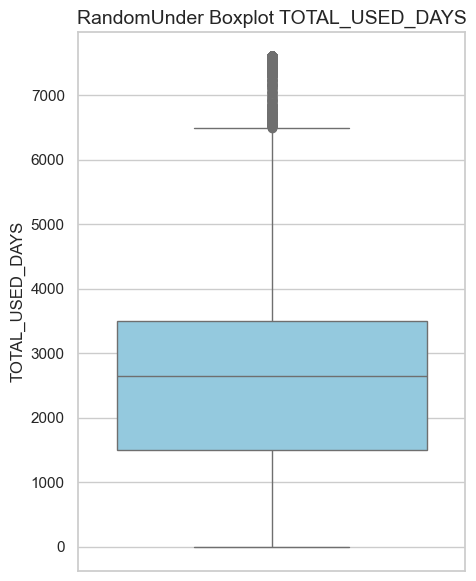

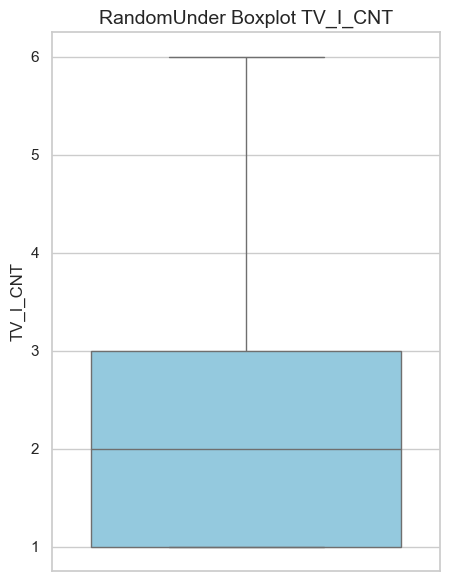

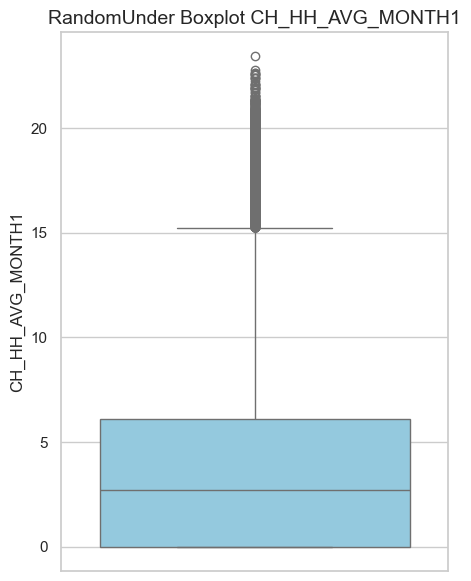

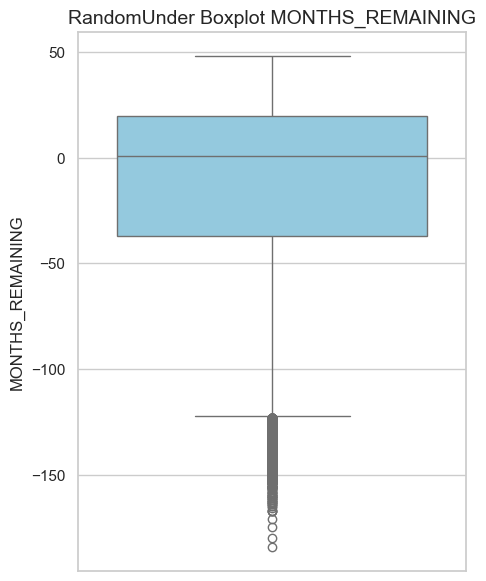

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# df에서 연속형(수치형) 변수 찾기
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

sns.set(style="whitegrid")

# 각 연속형 변수에 대해 boxplot
for col in numeric_columns:
    plt.figure(figsize=(5, 7))
    sns.boxplot(y=train[col], color="skyblue")

    plt.ylabel(col, fontsize=12)
    plt.title(f'RandomUnder Boxplot {col}', fontsize=14)

    plt.show()

In [49]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# boxplot으로 확인한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1', 'MONTHS_REMAINING']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


In [50]:
display(train, test)

,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
0,0.50,0.00,1.00,0.83,0.00,0.00,0.11,0.40,0.08,0.09,1.00,0.40,0.80,0.00,0.00,0.50,0.52,0.00,1.00,0.00,0.00,0.28,0
1,0.75,0.50,0.00,0.33,0.00,0.00,0.44,0.60,0.62,-0.16,1.00,0.20,0.80,0.00,0.00,0.12,1.27,1.00,1.00,0.00,0.00,-0.72,0
2,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.08,0.22,0.00,0.20,0.80,0.00,0.00,0.50,1.24,0.00,1.00,0.00,1.00,0.47,0
3,0.50,0.00,0.00,0.83,0.00,0.00,0.44,0.10,0.08,0.58,1.00,0.20,0.80,0.00,0.00,0.38,-0.10,0.00,1.00,0.00,0.00,0.33,0
4,0.00,0.00,0.00,0.83,0.00,0.00,0.11,0.00,0.08,0.64,1.00,0.40,0.40,1.00,0.00,0.88,-0.39,0.00,1.00,0.00,0.00,0.32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211407,0.50,0.00,1.00,0.83,1.00,0.00,0.44,0.00,0.08,0.54,1.00,0.20,0.80,0.00,0.00,0.50,-0.13,0.00,1.00,0.00,0.00,0.51,1
211408,0.00,0.00,0.75,0.00,1.00,0.00,0.11,0.00,0.08,-1.07,1.00,0.20,0.20,0.00,0.00,0.12,-0.44,0.00,0.00,0.00,0.00,0.33,1
211409,1.00,0.50,1.00,0.00,1.00,0.00,1.00,0.00,0.08,-1.32,1.00,0.20,0.80,1.00,0.00,0.38,0.13,1.00,1.00,0.00,0.00,0.61,1
211410,0.75,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.08,-1.21,0.00,0.00,1.00,0.00,0.00,0.38,-0.34,0.00,1.00,0.00,0.00,0.49,1


,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
0,0.25,0.00,0.75,0.83,0.00,0.00,0.00,0.30,0.08,-0.82,1.00,0.40,0.80,0.00,0.00,0.50,0.58,0.00,1.00,0.00,0.00,0.56,0
1,0.25,0.00,1.00,0.83,0.00,0.00,0.00,0.80,0.46,0.88,1.00,0.20,0.80,0.00,0.00,0.38,2.08,0.00,1.00,1.00,1.00,0.11,0
2,0.50,0.00,0.00,0.83,0.00,0.00,0.44,0.10,0.08,-0.00,1.00,1.00,0.80,0.00,0.00,0.50,-0.20,0.00,1.00,0.00,1.00,0.33,0
3,0.50,0.00,0.75,0.00,0.00,0.00,0.44,0.10,1.00,-0.33,0.00,0.40,0.80,0.00,0.00,0.50,-0.09,0.00,1.00,1.00,0.00,-0.19,0
4,0.50,0.00,1.00,0.00,0.00,0.33,1.00,0.00,0.62,0.67,1.00,0.60,0.80,1.00,0.00,0.38,-0.18,0.00,1.00,0.00,0.00,-0.91,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945587,0.50,0.00,0.00,0.83,0.00,0.00,1.00,0.00,0.62,0.48,0.00,0.20,0.20,0.00,0.00,0.38,-0.44,0.00,0.00,0.00,0.00,-0.86,0
1945588,0.50,0.00,0.75,0.00,0.00,0.00,0.11,0.10,0.62,-0.18,1.00,0.40,0.80,0.00,0.00,0.25,-0.15,0.00,1.00,0.00,0.00,-0.70,0
1945589,0.00,0.00,0.75,0.33,0.00,0.00,0.44,0.00,0.62,0.66,0.00,0.20,0.80,0.00,0.00,0.12,-0.17,0.00,1.00,0.00,0.00,-1.93,0
1945590,0.50,0.50,0.00,0.83,0.00,0.00,0.00,0.30,0.08,-0.55,1.00,0.20,0.80,0.00,0.00,0.38,0.11,0.00,1.00,0.00,0.00,0.32,0


In [51]:
# 로지스틱 회귀 모델 진행

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train.drop(columns=['churn'])
y_train = train['churn']

# 로지스틱 회귀 모델 생성
#
model = LogisticRegression(solver='liblinear', random_state=42)

# 모델 학습
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Test Accuracy: 0.78

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.78      0.88   1932416
           1       0.02      0.70      0.04     13176

    accuracy                           0.78   1945592
   macro avg       0.51      0.74      0.46   1945592
weighted avg       0.99      0.78      0.87   1945592


Confusion Matrix (테스트 데이터):
[[1512972  419444]
 [   4003    9173]]


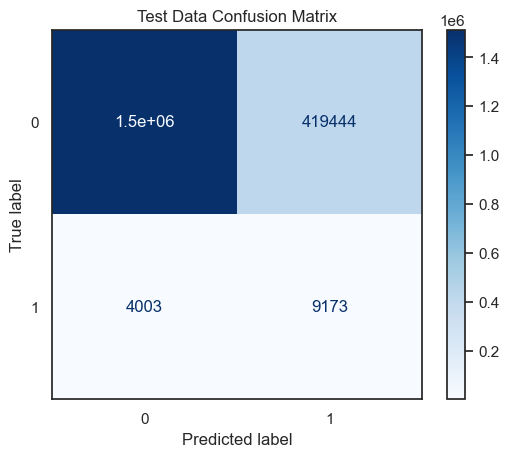

Test AUC-ROC: 0.81


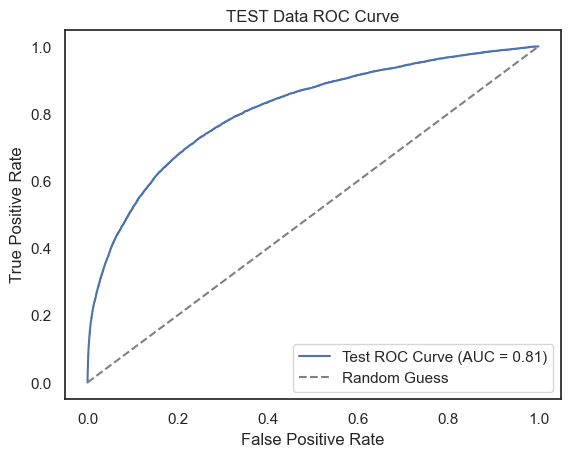

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

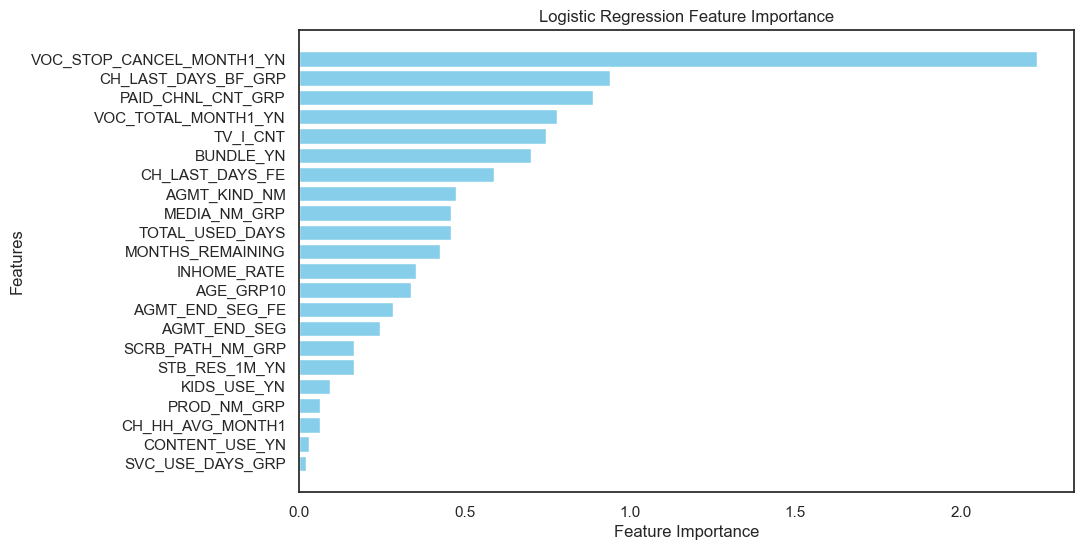

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Feature Importance 추출 (절댓값 사용)
feature_importance = np.abs(model.coef_[0])

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()

#### 2. 랜덤 포레스트 랜덤 언더 샘플링

In [55]:
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# 랜덤 포레스트 모델
rf_model = RandomForestClassifier(
    n_estimators=100,  # 트리 개수
    random_state=42
)

# 모델 학습
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Test Accuracy: 0.81

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   1932416
           1       0.02      0.71      0.05     13176

    accuracy                           0.81   1945592
   macro avg       0.51      0.76      0.47   1945592
weighted avg       0.99      0.81      0.89   1945592


Confusion Matrix (테스트 데이터):
[[1558446  373970]
 [   3860    9316]]


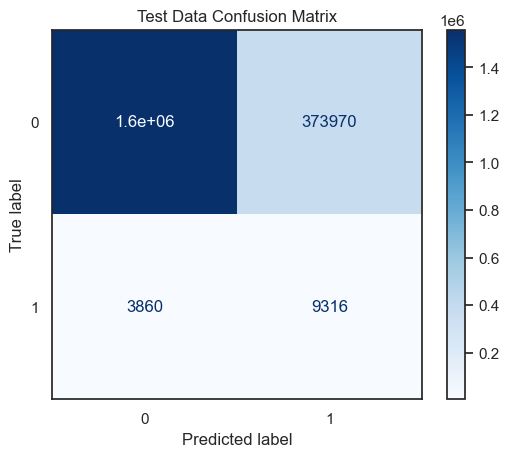

Test AUC-ROC: 0.83


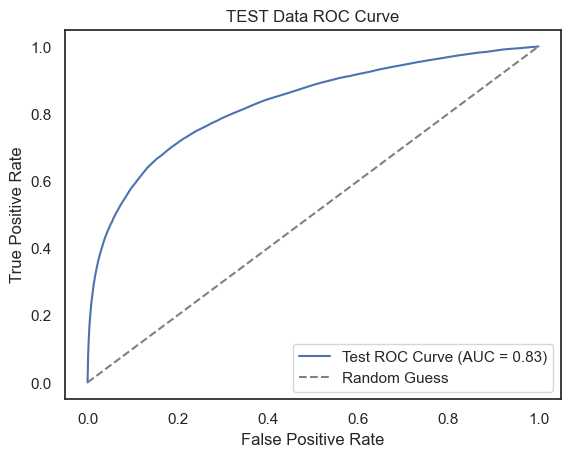

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = rf_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=rf_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = rf_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

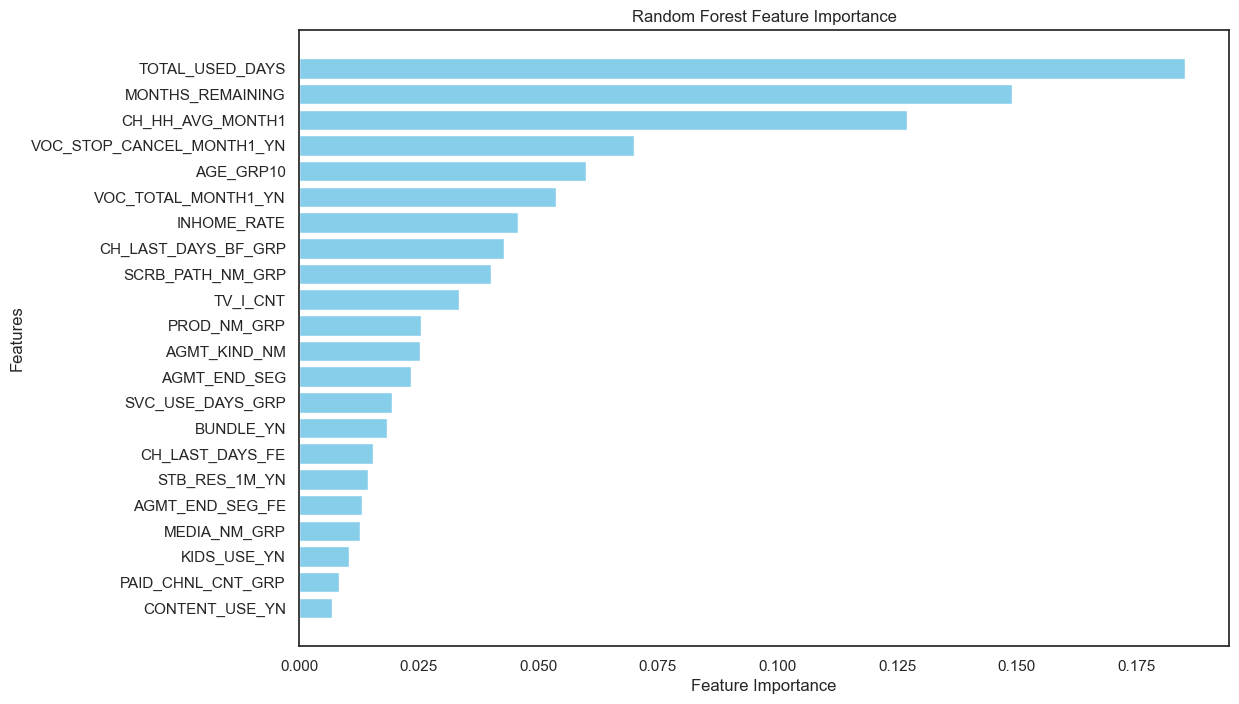

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

#### 3. XGB 랜덤 언더 샘플링

In [58]:
from xgboost import XGBClassifier

X_train = train.drop(columns=['churn'])
y_train = train['churn']

# XGBoost 모델 생성
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# 모델 학습
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Test Accuracy: 0.82

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1932416
           1       0.03      0.73      0.05     13176

    accuracy                           0.82   1945592
   macro avg       0.51      0.78      0.47   1945592
weighted avg       0.99      0.82      0.89   1945592


Confusion Matrix (테스트 데이터):
[[1579253  353163]
 [   3520    9656]]


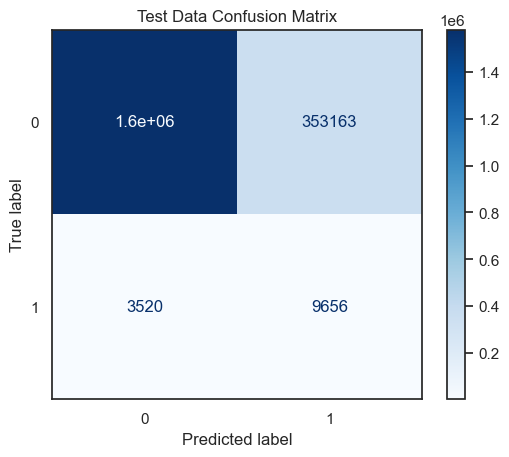

Test AUC-ROC: 0.85


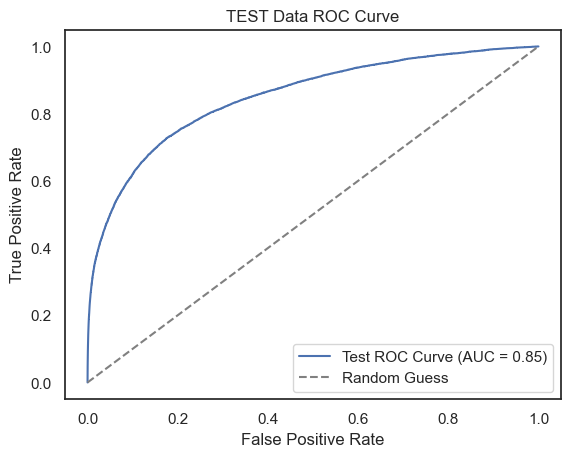

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = xgb_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=xgb_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = xgb_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

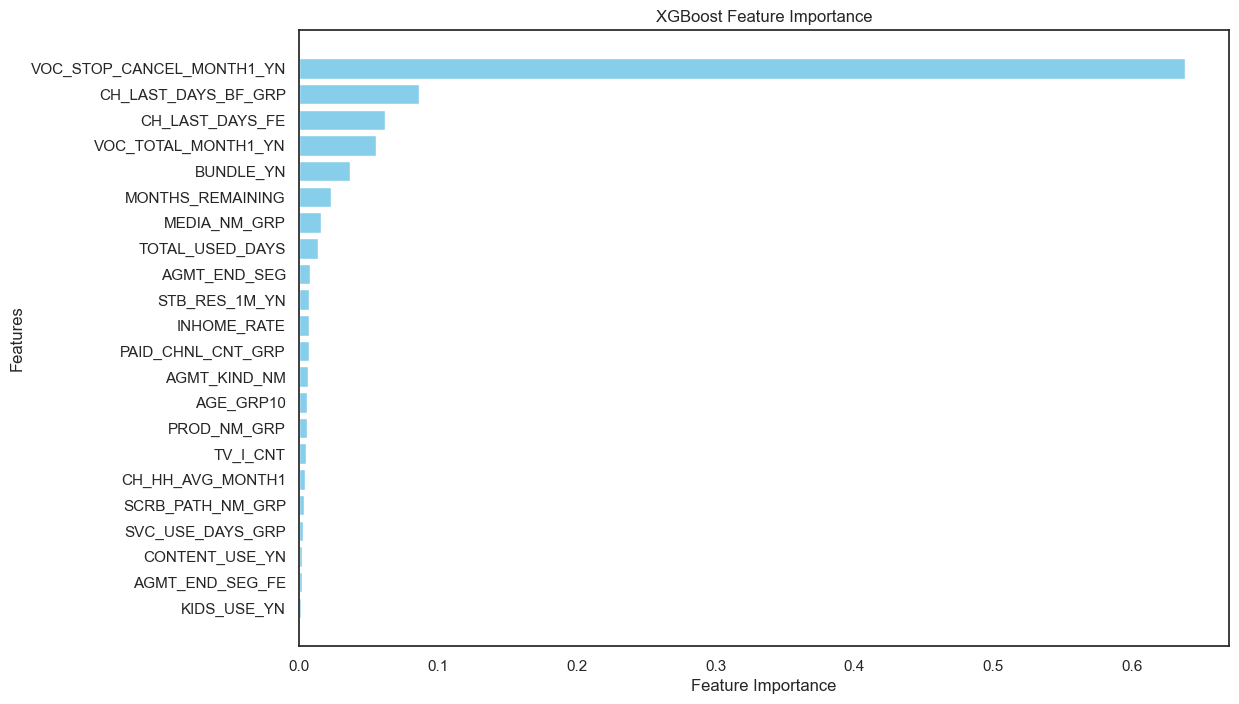

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# XGBoost Feature Importance 추출
feature_importance = xgb_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

#### 4. LGBM 랜덤 언더 샘플링

In [61]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(random_state=42)

Test Accuracy: 0.82

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1932416
           1       0.03      0.73      0.05     13176

    accuracy                           0.82   1945592
   macro avg       0.51      0.77      0.48   1945592
weighted avg       0.99      0.82      0.89   1945592


Confusion Matrix (테스트 데이터):
[[1581716  350700]
 [   3547    9629]]


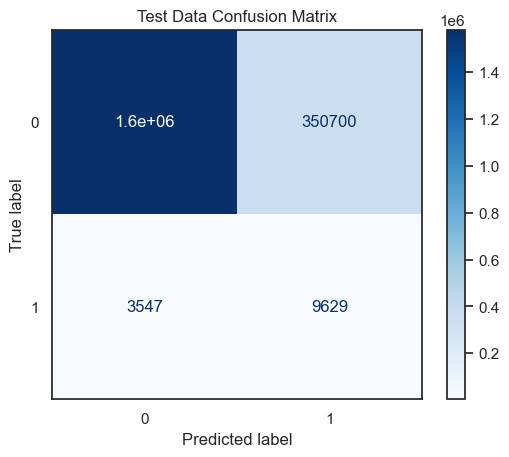

Test AUC-ROC: 0.85


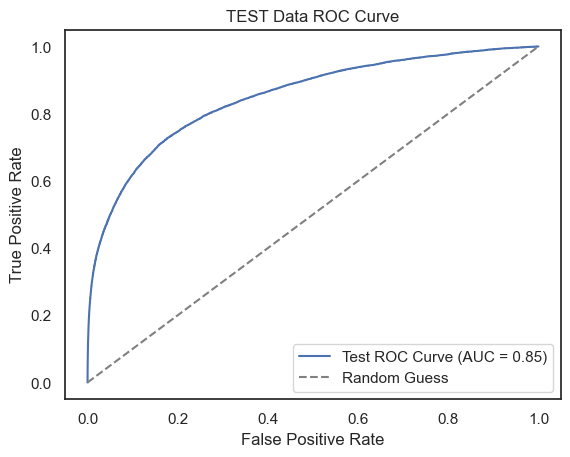

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = lgbm_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=lgbm_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

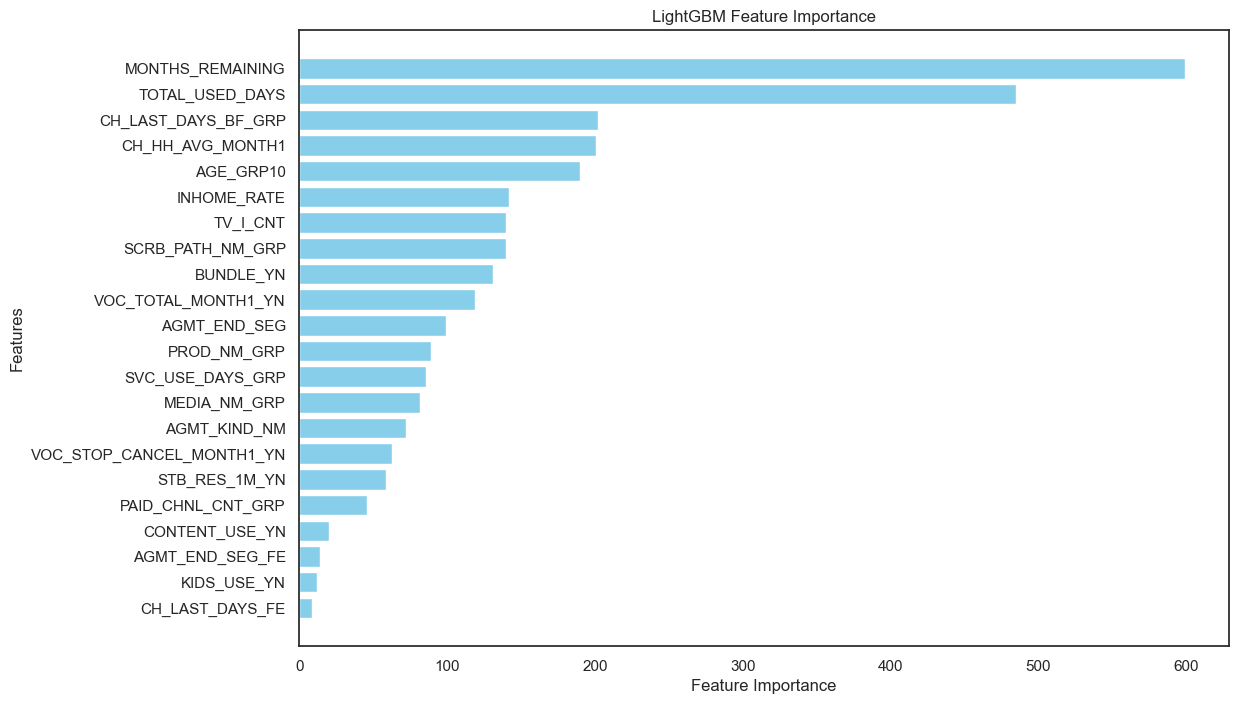

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# LightGBM Feature Importance 추출
feature_importance = lgbm_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

#### 5. CatBoost 랜덤 언더 샘플링

In [64]:
from catboost import CatBoostClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# 기본값을 사용한 CatBoost 모델 생성
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42
)

# 모델 학습
cat_model.fit(X_train, y_train)

0:	learn: 0.6797031	total: 171ms	remaining: 2m 51s
1:	learn: 0.6671393	total: 210ms	remaining: 1m 44s
2:	learn: 0.6554904	total: 243ms	remaining: 1m 20s
3:	learn: 0.6450984	total: 270ms	remaining: 1m 7s
4:	learn: 0.6353696	total: 293ms	remaining: 58.2s
5:	learn: 0.6262875	total: 315ms	remaining: 52.2s
6:	learn: 0.6179714	total: 340ms	remaining: 48.2s
7:	learn: 0.6102105	total: 363ms	remaining: 45s
8:	learn: 0.6031074	total: 388ms	remaining: 42.7s
9:	learn: 0.5969630	total: 456ms	remaining: 45.1s
10:	learn: 0.5912653	total: 495ms	remaining: 44.5s
11:	learn: 0.5855908	total: 528ms	remaining: 43.5s
12:	learn: 0.5804210	total: 553ms	remaining: 42s
13:	learn: 0.5754965	total: 580ms	remaining: 40.8s
14:	learn: 0.5710877	total: 607ms	remaining: 39.9s
15:	learn: 0.5671514	total: 636ms	remaining: 39.1s
16:	learn: 0.5632695	total: 658ms	remaining: 38.1s
17:	learn: 0.5601500	total: 686ms	remaining: 37.4s
18:	learn: 0.5567110	total: 719ms	remaining: 37.1s
19:	learn: 0.5538226	total: 752ms	remainin

Test Accuracy: 0.82

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1932416
           1       0.03      0.73      0.05     13176

    accuracy                           0.82   1945592
   macro avg       0.51      0.77      0.47   1945592
weighted avg       0.99      0.82      0.89   1945592


Confusion Matrix (테스트 데이터):
[[1578968  353448]
 [   3520    9656]]


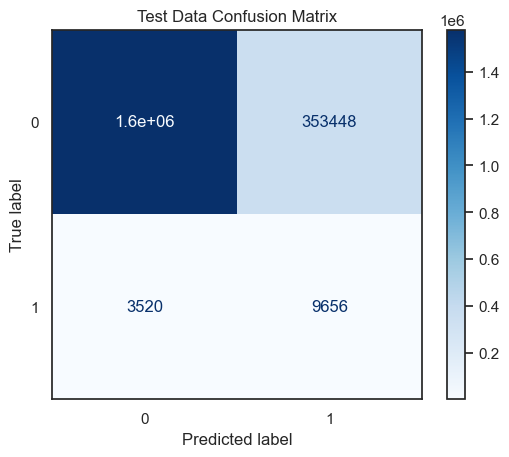

Test AUC-ROC: 0.85


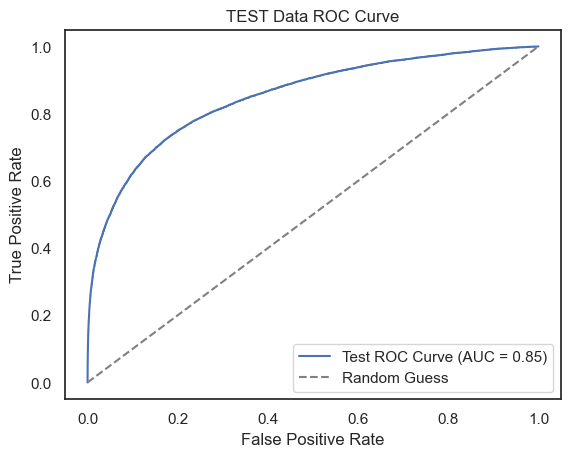

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = cat_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=cat_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = cat_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

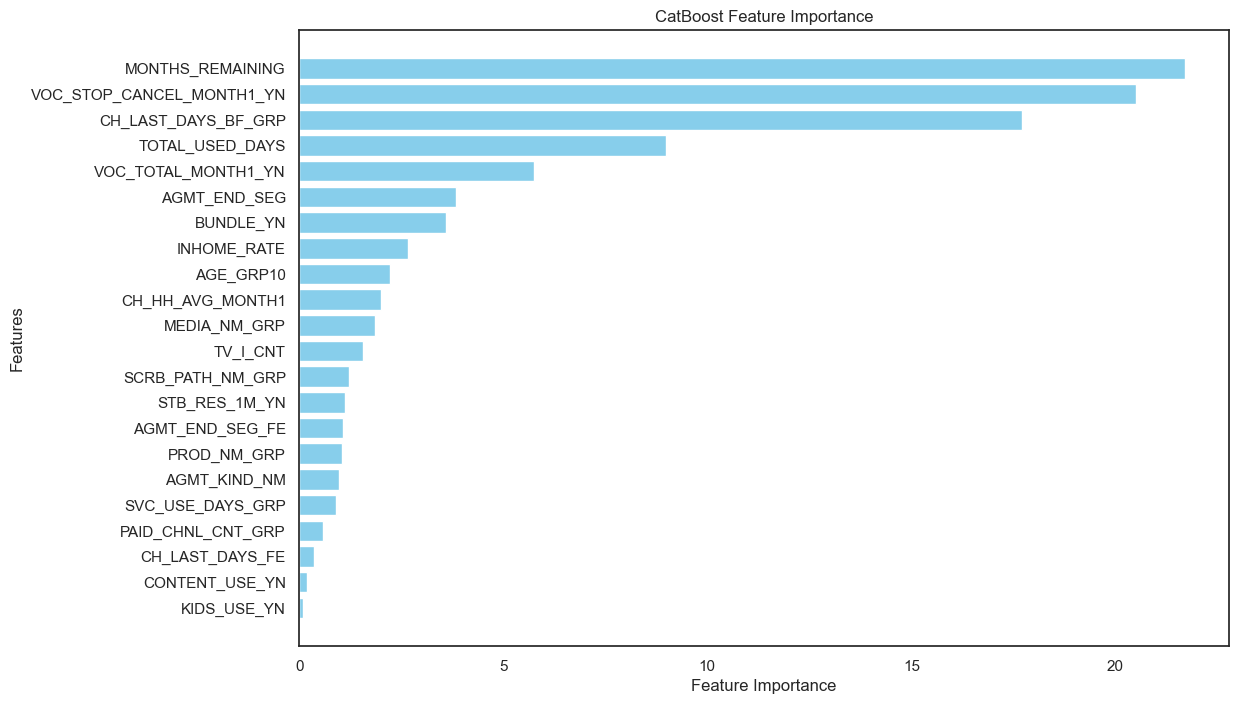

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# CatBoost Feature Importance 추출
feature_importance = cat_model.get_feature_importance()

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()


---

### 가중치로 진행
1. 로지스틱
2. LGBM

#### 1. LR 가중치

In [67]:
df = df_real.filter(items=['sha2_hash','SVC_USE_DAYS_GRP','MEDIA_NM_GRP','PROD_NM_GRP','AGMT_KIND_NM','STB_RES_1M_YN',
                 'PAID_CHNL_CNT_GRP','SCRB_PATH_NM_GRP','INHOME_RATE','AGMT_END_SEG','TOTAL_USED_DAYS','BUNDLE_YN',
                 'TV_I_CNT','CH_LAST_DAYS_BF_GRP','VOC_TOTAL_MONTH1_YN','VOC_STOP_CANCEL_MONTH1_YN','AGE_GRP10',
                 'CH_HH_AVG_MONTH1','CONTENT_USE_YN','CH_LAST_DAYS_FE','AGMT_END_SEG_FE','KIDS_USE_YN','MONTHS_REMAINING',
                 'p_mt','churn'])

In [8]:
train = df[df['p_mt'].isin([2,3,4,5,6,7,8,9])]
test = df[df['p_mt'] == 11]

In [9]:
train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object


In [10]:
train = train.drop(columns=['sha2_hash','p_mt'])
test = test.drop(columns=['sha2_hash','p_mt'])

In [11]:
from sklearn.preprocessing import LabelEncoder

train_and_test = pd.concat([train, test])

categorical_cols = train_and_test.select_dtypes(include=['object']).columns

label_encoders = {}

for col in categorical_cols:
  le = LabelEncoder()
  train_and_test[col] = le.fit_transform(train_and_test[col])
  label_encoders[col] = le

# 인코딩 후, 다시 train과 test로 분리

train = train_and_test.iloc[:len(train)].reset_index(drop=True)
test = train_and_test.iloc[len(train):].reset_index(drop=True)

print("레이블 인코딩 끝! 😁")

레이블 인코딩 끝! 😁


In [12]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# boxplot으로 확인한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1', 'MONTHS_REMAINING']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


In [13]:
display(train, test)

,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
0,0.00,0.00,0.80,0.00,0.00,0.00,0.00,0.10,0.08,-1.41,1.00,0.40,0.20,0.00,0.00,0.56,-0.65,0.00,0.00,0.00,0.00,0.08,0
1,0.25,0.00,0.80,0.00,1.00,0.00,0.00,0.00,0.54,-1.39,1.00,0.40,0.80,1.00,0.00,0.56,0.50,0.00,1.00,1.00,0.00,0.07,0
2,0.25,0.00,0.80,0.00,0.00,0.00,0.00,0.10,0.54,-1.37,1.00,0.40,0.40,0.00,0.00,0.56,1.03,0.00,1.00,1.00,0.00,0.05,0
3,0.25,0.00,0.80,0.00,0.00,0.00,0.00,0.10,0.54,-1.35,1.00,0.40,0.60,0.00,0.00,0.56,0.37,0.00,1.00,1.00,0.00,0.03,0
4,0.25,0.00,0.80,0.00,0.00,0.00,0.00,0.00,0.46,-1.33,1.00,0.40,0.80,0.00,0.00,0.56,0.04,0.00,1.00,1.00,0.00,0.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15647031,0.50,0.00,0.20,0.00,0.00,0.00,1.00,0.10,0.62,-0.42,0.00,0.00,0.80,0.00,0.00,0.44,-0.02,0.00,1.00,0.00,1.00,-0.75,0
15647032,0.50,0.00,0.20,0.00,0.00,0.00,1.00,0.10,0.62,-0.40,0.00,0.00,0.80,0.00,0.00,0.44,-0.11,0.00,1.00,0.00,1.00,-0.77,0
15647033,0.50,0.00,0.20,0.00,0.00,0.00,1.00,0.10,0.62,-0.38,0.00,0.00,0.80,0.00,0.00,0.44,0.05,0.00,1.00,0.00,1.00,-0.78,0
15647034,0.50,0.00,0.20,0.00,0.00,0.00,1.00,0.10,0.62,-0.36,0.00,0.00,0.80,0.00,0.00,0.44,-0.30,0.00,1.00,0.00,0.00,-0.80,0


,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
0,0.25,0.00,0.80,0.83,0.00,0.00,0.00,0.30,0.08,-1.23,1.00,0.40,0.80,0.00,0.00,0.56,0.41,0.00,1.00,0.00,0.00,0.42,0
1,0.25,0.00,1.00,0.83,0.00,0.00,0.00,0.80,0.46,1.00,1.00,0.20,0.80,0.00,0.00,0.44,1.97,0.00,1.00,1.00,1.00,-0.02,0
2,0.50,0.00,0.20,0.83,0.00,0.00,0.44,0.10,0.08,-0.16,1.00,1.00,0.80,0.00,0.00,0.56,-0.40,0.00,1.00,0.00,1.00,0.20,0
3,0.50,0.00,0.80,0.00,0.00,0.00,0.44,0.10,1.00,-0.58,0.00,0.40,0.80,0.00,0.00,0.56,-0.28,0.00,1.00,1.00,0.00,-0.30,0
4,0.50,0.00,1.00,0.00,0.00,0.33,1.00,0.00,0.62,0.72,1.00,0.60,0.80,1.00,0.00,0.44,-0.37,0.00,1.00,0.00,0.00,-0.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945587,0.50,0.00,0.20,0.83,0.00,0.00,1.00,0.00,0.62,0.47,0.00,0.20,0.20,0.00,0.00,0.44,-0.65,0.00,0.00,0.00,0.00,-0.93,0
1945588,0.50,0.00,0.80,0.00,0.00,0.00,0.11,0.10,0.62,-0.39,1.00,0.40,0.80,0.00,0.00,0.33,-0.34,0.00,1.00,0.00,0.00,-0.78,0
1945589,0.00,0.00,0.80,0.33,0.00,0.00,0.44,0.00,0.62,0.70,0.00,0.20,0.80,0.00,0.00,0.22,-0.36,0.00,1.00,0.00,0.00,-1.95,0
1945590,0.50,0.50,0.20,0.83,0.00,0.00,0.00,0.30,0.08,-0.87,1.00,0.20,0.80,0.00,0.00,0.44,-0.07,0.00,1.00,0.00,0.00,0.18,0


In [14]:
# 로지스틱 회귀 모델 진행

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train.drop(columns=['churn'])
y_train = train['churn']

# 로지스틱 회귀 모델 생성
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)

# 모델 학습
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

Test Accuracy: 0.78

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.78      0.88   1932416
           1       0.02      0.70      0.04     13176

    accuracy                           0.78   1945592
   macro avg       0.51      0.74      0.46   1945592
weighted avg       0.99      0.78      0.87   1945592


Confusion Matrix (테스트 데이터):
[[1511491  420925]
 [   3995    9181]]


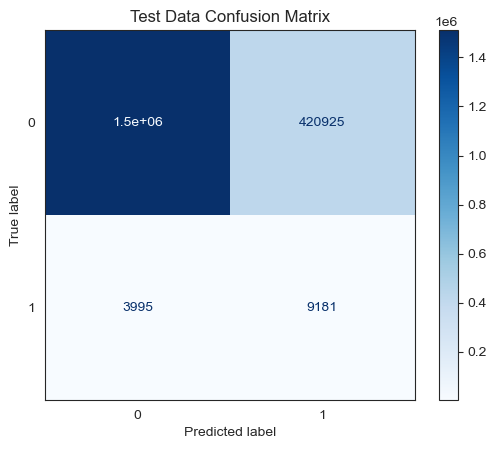

Test AUC-ROC: 0.81


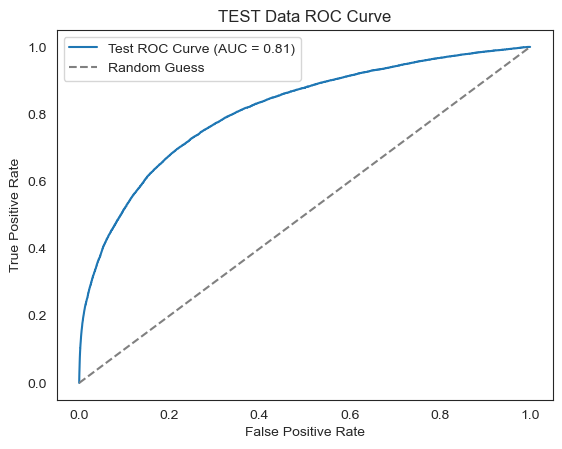

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

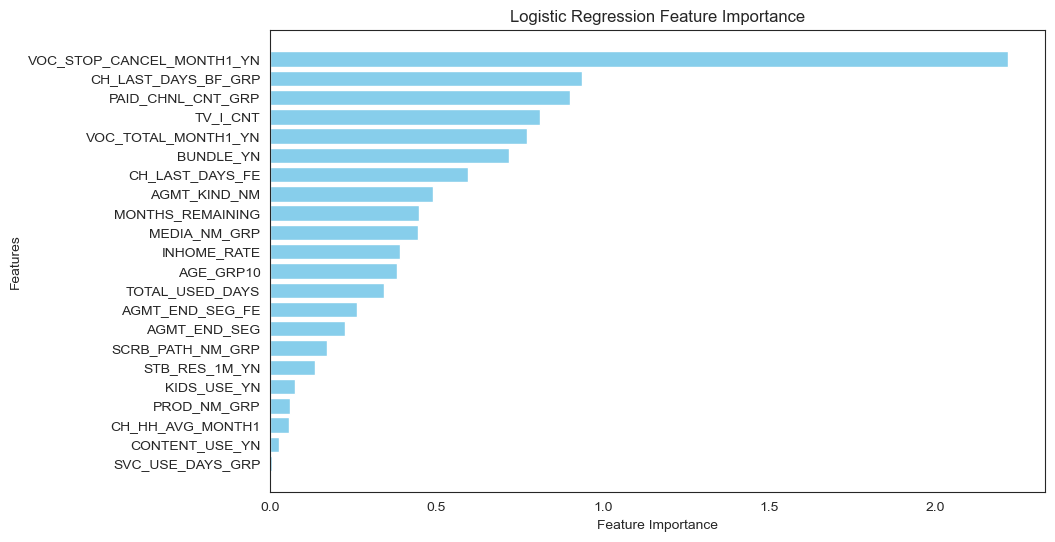

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = np.abs(model.coef_[0])

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

#### 2. LGBM 가중치

In [18]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    class_weight='balanced',  # 클래스 가중치 적용
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

Test Accuracy: 0.82

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1932416
           1       0.03      0.73      0.05     13176

    accuracy                           0.82   1945592
   macro avg       0.51      0.78      0.48   1945592
weighted avg       0.99      0.82      0.89   1945592


Confusion Matrix (테스트 데이터):
[[1584487  347929]
 [   3541    9635]]


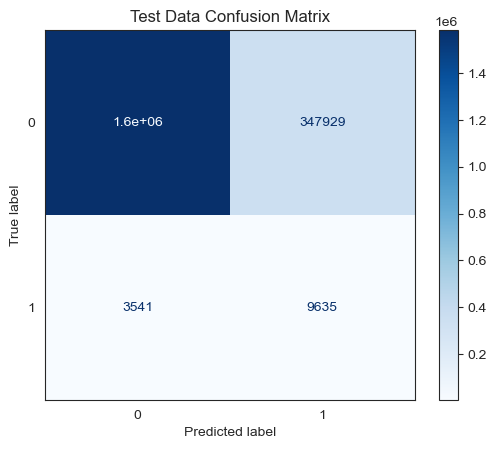

Test AUC-ROC: 0.85


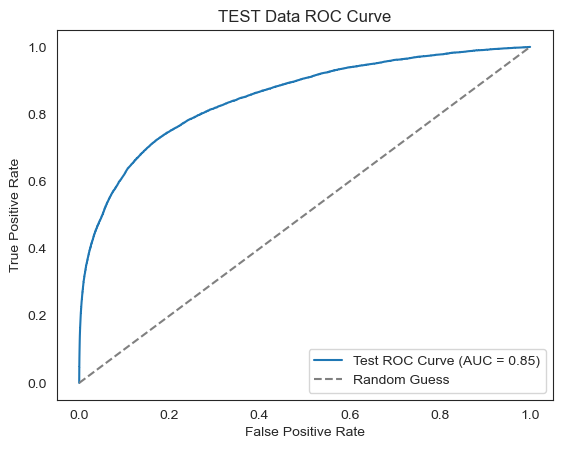

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = lgbm_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=lgbm_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

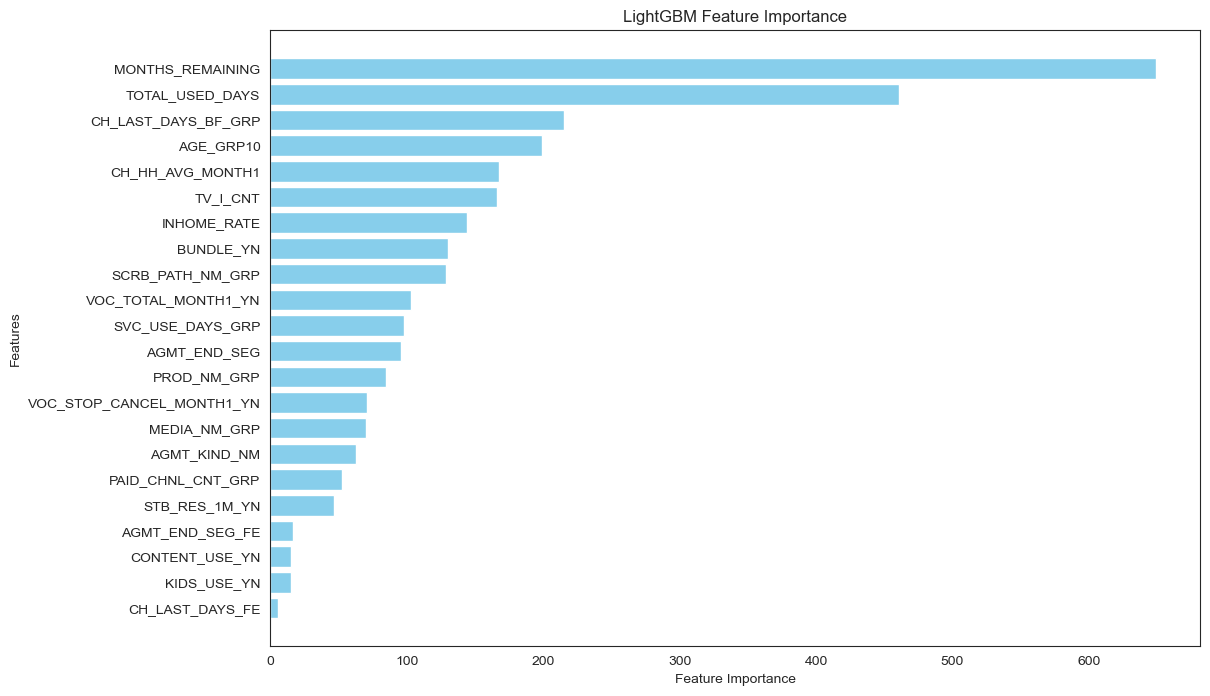

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# LightGBM Feature Importance 추출
feature_importance = lgbm_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

#### 📌 팀 프로젝트 주제에 알맞은 모델 선택 기준

##### 1️. FN(False Negative) 감소  
- 실제 해지 고객(1)을 모델이 해지가 아니라고 예측한 경우(FN)
- **FN이 높을수록, 해지할 고객을 제대로 예측하지 못한 것**이므로 **최대한 줄여야 함**  

##### 2️. TP(True Positive) 증가  
- 실제 해지 고객(1)을 모델이 올바르게 해지라고 예측한 경우(TP) 
- **TP 값을 높여야 해지할 고객을 정확히 찾아낼 수 있음**

##### 3️. FP(False Positive) 최소화  
- 실제 해지가 아닌 고객(0)을 모델이 해지라고 예측한 경우(FP)
- FP는 단순한 경고로 끝날 수 있으므로 완전히 없애야 할 필요는 없지만, **가능한 줄이는 것이 좋음**


#### 📌 결론  
✅ **FN(실제 해지를 놓친 경우)를 줄이고, TP(정확한 해지 예측)를 최대한 높이는 모델이 가장 적합함**<BR>
✅ **FP(잘못된 해지 예측)는 어느 정도 감수할 수 있지만, 너무 많으면 고객 경험에 부정적인 영향을 줄 수 있음**<BR>
✅ **따라서, Recall(재현율)과 Precision(정밀도) 균형을 고려하여 최적의 모델을 선택해야 함**.

해당 모델 선정 기준으로 1차 선정된 Feature들로 모델을 진행한 결과, <br><br>
**XGB(랜덤 언더 샘플링)**에서 제일 좋은 성능을 보여줬다.<BR><BR>

---

1차 선정된 컬럼들 + Feature Engineering을 통한 파생변수들로 모델링을 진행하였고, <br><br>
이 중에서도 또 영향력이 높은 컬럼들을 선정해서 2차 선정된 컬럼들로 모델링을 한 번 더 진행해보겠다.